In [125]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBRFClassifier

from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from yellowbrick.classifier import ConfusionMatrix, ROCAUC


# Import labeled data

In [64]:
labeled_df = pd.read_csv("../data/user_labeled/final_labeled.csv")
print(labeled_df.label.value_counts())
labeled_df

after     128
before    128
Name: label, dtype: int64


,node,label,degree,category_matches_with_source,in_edges,out_edges,shared_neighbors_with_entry_score,centrality,page_rank,adjusted_reciprocity,shortest_path_length_from_entry,shortest_path_length_to_entry,jaccard_similarity,primary_link,similarity_rank
0,Pitch contour,before,0.005948,0.500000,0.003660,0.013499,0.003672,0.005395,0.005592,0.032787,0.111111,0.4,0.002206,1.0,1.000000
1,Contrapuntal motion,before,0.002721,0.500000,0.001961,0.004846,0.016748,0.005917,0.003279,0.005855,0.111111,0.2,0.013647,0.0,0.777372
2,False relation,before,0.005758,0.500000,0.003203,0.014884,0.017125,0.006395,0.004419,0.029274,0.111111,0.2,0.014211,0.0,0.739844
3,Consecutive fifths,before,0.007530,0.500000,0.002092,0.030460,0.024269,0.008024,0.002905,0.008197,0.111111,0.2,0.009043,0.0,0.719724
4,Part (music),before,0.014238,0.000000,0.008627,0.032537,0.038132,0.015269,0.018632,0.050351,0.111111,0.2,0.026391,1.0,0.661378
5,Common practice period,after,0.017212,0.000000,0.013791,0.021461,0.063220,0.056626,0.017873,0.035129,0.111111,0.2,0.060056,1.0,0.650981
6,Monophony,before,0.016642,0.500000,0.012614,0.024576,0.017769,0.008420,0.024175,0.028103,0.111111,0.2,0.013514,0.0,0.622047
7,The Well-Tempered Clavier,after,0.033854,0.500000,0.018301,0.088612,0.036702,0.059787,0.015477,0.117096,0.111111,0.2,0.025856,0.0,0.519419
8,Post-tonal music theory,after,0.006518,0.500000,0.002092,0.024922,0.022684,0.007004,0.002093,0.028103,0.222222,0.2,0.006767,0.0,0.508584
9,Atmosphères,after,0.009302,0.500000,0.003137,0.034614,0.015248,0.004193,0.001571,0.048009,0.222222,0.2,0.004448,0.0,0.490293


# Exploration - PCA Plotting

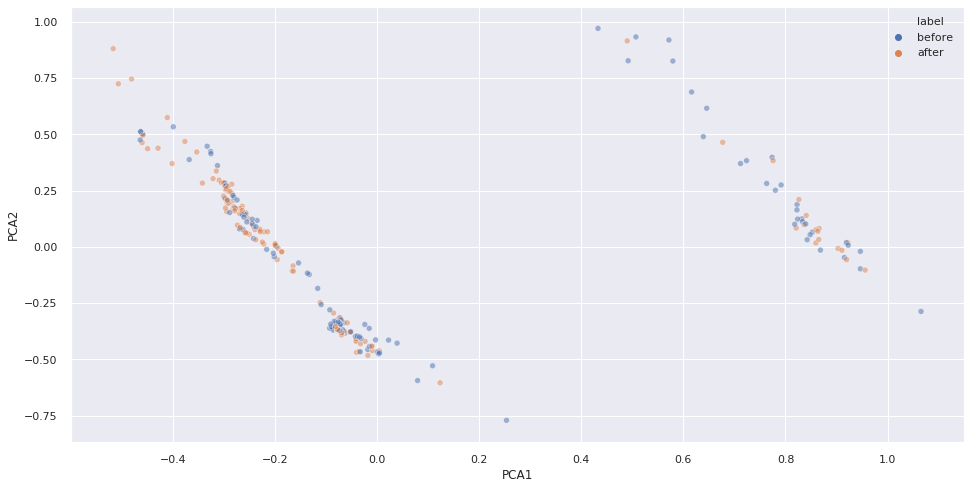

In [65]:
pca = PCA(n_components = 2, )

components_df = pd.DataFrame(pca.fit_transform(labeled_df.drop(["node", "label"], axis=1)),
                            columns=["PCA1", "PCA2"])

components_df['label'] = labeled_df['label']

# components_df = components_df[components_df.PCA1 > 0.2]

# components_df.label.value_counts()

plt.figure(figsize=(16,8))
sns.scatterplot(data=components_df, x="PCA1", y='PCA2', hue='label', alpha=0.5)

# Test Train Split

In [144]:
X = labeled_df.drop([
    "node", 
    "label", 
    "similarity_rank",
    
    # trimming less valuable estimators
#     "shortest_path_length_to_entry",
#     "primary_link",
#     "category_matches_with_source",
#     "shortest_path_length_from_entry",
#     "in_edges",
#     "adjusted_reciprocity",
    
], axis=1)
y = labeled_df.label

cols = X.columns 

ros = RandomOverSampler()
rus = RandomUnderSampler()

## class imbalance undersampling
# X, y = rus.fit_sample(X, y)

# X = pd.DataFrame(X, columns=cols)
# y = pd.Series(y)

#basic train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)


## class imbalance oversampling 
# X_train, y_train = ros.fit_sample(X_train, y_train)
# X_train = pd.DataFrame(X_train, columns=cols)
# y_train = pd.Series(y_train)

# X_test, y_test = ros.fit_sample(X_test, y_test)
# X_test = pd.DataFrame(X_test, columns=cols)
# y_test = pd.Series(y_test)

print("Train Classes:")
print(y_train.value_counts(), "\n")
print("Test Classes:")
print(y_test.value_counts(), "\n")

Train Classes:
after     103
before    101
Name: label, dtype: int64 

Test Classes:
before    27
after     25
Name: label, dtype: int64 



# Random Forest

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished
/home/qdizon/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Params:	 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 10, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1000} 


              precision    recall  f1-score   support

       after       0.74      0.80      0.77        25
      before       0.80      0.74      0.77        27

    accuracy                           0.77        52
   macro avg       0.77      0.77      0.77        52
weighted avg       0.77      0.77      0.77        52

Train Score:	 0.8529411764705882
Test Score:	 0.7692307692307693


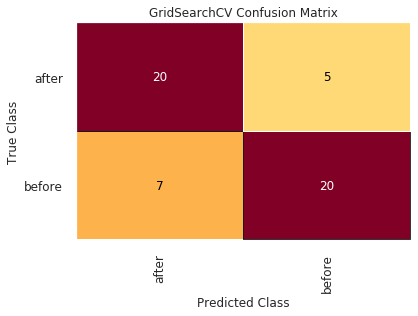

In [ ]:
rf = RandomForestClassifier(n_jobs=-1, random_state=42)

# GridSearch params
params = {
#     "pca__n_components": [4,5,6,7,8,9],
    
    "criterion": ["entropy"], # entropy
    "n_estimators": [1000], # 100
    "max_depth": [10], # 10
    "min_samples_split": [5], # 5
    "min_samples_leaf": [10], # 10
    "max_leaf_nodes": [10], # 8
    "bootstrap": [True]
    
}

rf_model = GridSearchCV(rf, params, n_jobs=-1, cv=3, verbose=2)

rf_model.fit(X_train, y_train)

y_preds = rf_model.predict(X_test)

cm = ConfusionMatrix(rf_model, classes=rf_model.classes_, is_fitted=True)
visualizer = ROCAUC(rf_model, classes=rf_model.classes_, is_fitted=True)

print("Best Params:\t", rf_model.best_params_, "\n\n")
print(classification_report(y_test, y_preds, target_names=rf_model.classes_))
print("Train Score:\t", rf_model.score(X_train, y_train))
print("Test Score:\t", cm.score(X_test, y_test))
cm.poof()


visualizer.score(X_test, y_test)
visualizer.poof()

In [42]:

best_estimators = pd.DataFrame(list(zip(X_train.columns, rf_model.best_estimator_.feature_importances_)), 
             columns=["Feature", "Estimation Strength"])

best_estimators.sort_values("Estimation Strength", ascending=False)

,Feature,Estimation Strength
5,page_rank,0.214518
3,shared_neighbors_with_entry_score,0.190361
8,jaccard_similarity,0.164840
4,centrality,0.096316
0,degree,0.082292
6,adjusted_reciprocity,0.082232
2,out_edges,0.082111
1,in_edges,0.070768
7,shortest_path_length_from_entry,0.016563


# XG Boost

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Train Score:	 0.7843137254901961
Test Score:	 0.7115384615384616


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
/home/qdizon/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


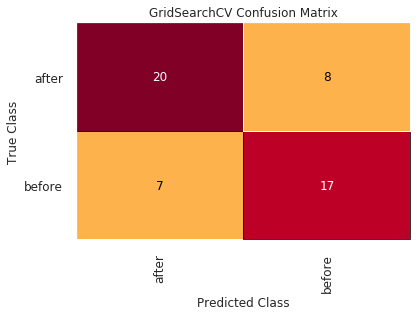

Best Params:	 {'gamma': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


In [101]:
model = XGBRFClassifier(random_state=10, )

params = { 
    "max_depth": [3],
    "n_estimators": [100, 200],
    "learning_rate": [0.01],
    "gamma": [1]
}

xg_model = GridSearchCV(model, params, n_jobs=-1, cv=3, verbose=2)

xg_model.fit(X_train, y_train)

cm = ConfusionMatrix(xg_model, classes=["after", "before"], is_fitted=True)

print("Train Score:\t", xg_model.score(X_train, y_train))
print("Test Score:\t", cm.score(X_test, y_test))
cm.poof()
print("Best Params:\t", xg_model.best_params_)

# SVM

Fitting 10 folds for each of 384 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:    3.2s


0.5961538461538461


[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:    3.7s finished
/home/qdizon/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/qdizon/.local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


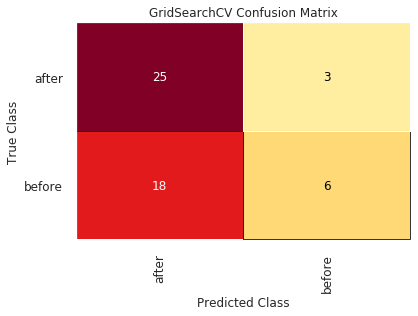

In [105]:
pca = PCA()
model = SVC()

steps = [
    ("pca", pca),
    ("svm", model)
]

pipe = Pipeline(steps)

params = {
    "pca__n_components": [2,3,4,5], 
    
    "svm__C": [0.001, 0.01, 0.1, 1, 10, 15],
    "svm__kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "svm__decision_function_shape": ['ovo', 'ovr'],
    "svm__shrinking": [True, False]
}

svc_model = GridSearchCV(pipe, params, n_jobs=-1, cv=10, verbose=2)

cm = ConfusionMatrix(svc_model, classes=["after", "before"])
cm.fit(X_train, y_train)

print(cm.score(X_test, y_test))

cm.poof()

# KNN

Fitting 3 folds for each of 176 candidates, totalling 528 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 528 out of 528 | elapsed:    6.0s finished
/home/qdizon/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.6538461538461539


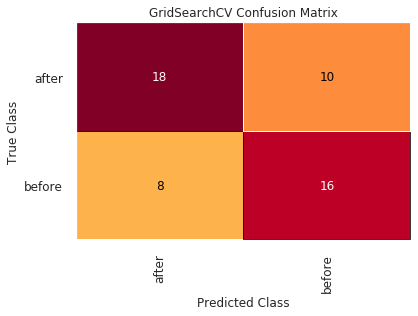

In [87]:
pca = PCA()
knn = KNeighborsClassifier(n_jobs=-1,)

steps = [
    ("pca", pca),
    ("knn", knn)
]

pipe = Pipeline(steps)

params = {
    "pca__n_components": [2,3,4,5], 
    
    "knn__n_neighbors": [k for k in range(5, 26) if k % 2 != 0],
    "knn__metric": ['minkowski', "euclidean", "chebyshev", "wminkowski"]
}

knn_model = GridSearchCV(pipe, params, n_jobs=-1, cv=3, verbose=2, scoring="accuracy", error_score=0.0)

cm = ConfusionMatrix(knn_model, classes=["after", "before"])
cm.fit(X_train, y_train)

print(cm.score(X_test, y_test))

cm.poof()

Best Params:	 {'priors': [0.5, 0.5]} 


Train Score:	 0.5784313725490197
Test Score:	 0.6153846153846154


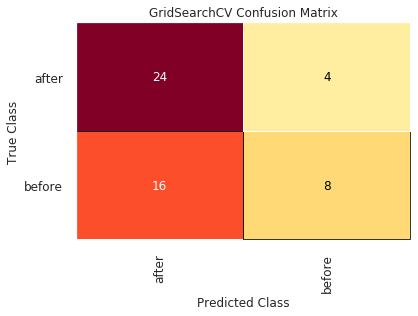

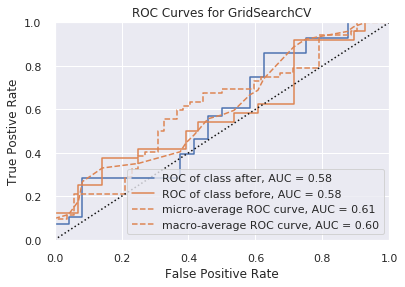

In [111]:
nb = GaussianNB()

params = {
    "priors": [[0.5, 0.5]],
}

nb_model = GridSearchCV(nb, param_grid=params, cv=3)

nb_model.fit(X_train, y_train)

cm = ConfusionMatrix(nb_model, classes=["after", "before"], is_fitted=True)
visualizer = ROCAUC(nb_model, classes=["after", "before"], is_fitted=True)


print("Best Params:\t", nb_model.best_params_, "\n\n")
print("Train Score:\t", nb_model.score(X_train, y_train))
print("Test Score:\t", cm.score(X_test, y_test))
cm.poof()


visualizer.score(X_test, y_test)
visualizer.poof()